In [1]:
from shapely.geometry.multipolygon import MultiPolygon

numbers_layers = ["номера"]
lines_layers = ["полосы"]
contours_layers = ["контуры"]
min_distance = 0.01

In [2]:
from pyautocad import Autocad
import pandas as pd
from pyautocad.utils import mtext_to_string
from shapely.geometry import Point
acad = Autocad()
numbers_data = []

for obj in acad.iter_objects(['AcDbText', 'AcDbMText']):
    if obj.ObjectName == 'AcDbText' and obj.Layer in numbers_layers:
        x, y, _ = obj.InsertionPoint
        numbers_data.append({
            'number': obj.TextString,
            'position': Point(x, y)
        })
    elif obj.ObjectName == 'AcDbMText' and obj.Layer in numbers_layers:
        x, y, _ = obj.InsertionPoint
        numbers_data.append({
            'number': mtext_to_string(obj.TextString).replace('\n', ' '),
            'position': Point(x, y)
        })

numbers_df = pd.DataFrame(numbers_data)
numbers_df

,number,position
0,1,POINT (3075.965582309878 1696.6051757815592)
1,2,POINT (3074.823165523758 1693.9006874227402)
2,3,POINT (3108.838205298518 1707.285109871409)
3,4,POINT (3114.150988844972 1707.4695572873902)
4,5,POINT (3115.690642463274 1707.5867820573599)
5,6,POINT (3115.1004453425708 1706.18062074892)
6,7,POINT (3114.699609216242 1705.0905155704238)
7,10,POINT (3104.043722283615 1698.543651078497)
8,11,POINT (3105.090899215862 1695.9481208535972)
9,12,POINT (3106.332887793542 1693.7013226121771)


In [3]:
from shapely.geometry import LineString, Polygon
acad = Autocad()
shapes_data = []
for obj in acad.iter_objects(['AcDbLine', 'AcDbPolyline', 'AcDbPolygon']):
    if obj.ObjectName == 'AcDbLine' and obj.Layer in lines_layers:
        shape = LineString([(obj.StartPoint[0], obj.StartPoint[1]),
                            (obj.EndPoint[0], obj.EndPoint[1])])
        shapes_data.append({
            'geometry': shape,
            'type': 'LineString'
        })
    elif obj.ObjectName == 'AcDbPolyline' and obj.Layer in lines_layers:
        acad_polygon_vertexes = [vertex for vertex in obj.Coordinates]
        shape = LineString(
            [(acad_polygon_vertexes[i], acad_polygon_vertexes[i+1]) 
             for i in range(0, len(acad_polygon_vertexes), 2)])
        shapes_data.append({
            'geometry': shape,
            'type': 'LineString'
        })
    elif obj.ObjectName == 'AcDbPolyline' and obj.Layer in contours_layers:
        acad_polygon_vertexes = [vertex for vertex in obj.Coordinates]
        shape = Polygon(
            [(acad_polygon_vertexes[i], acad_polygon_vertexes[i+1]) 
             for i in range(0, len(acad_polygon_vertexes), 2)])
        shapes_data.append({
            'geometry': shape,
            'type': 'Polygon'
        })
    # elif obj.ObjectName == 'AcDbPolyline' and obj.Layer in contours_layers:
    #     print(obj.ObjectName)

shapes_df = pd.DataFrame(shapes_data)
shapes_df

,geometry,type
0,"POLYGON ((3106.916523995033 1690.249262830753,...",Polygon
1,POLYGON ((3075.045526933311 1693.2592293092591...,Polygon
2,LINESTRING (3092.268998306507 1693.40414713145...,LineString
3,LINESTRING (3099.2754038714006 1706.8144261618...,LineString
4,POLYGON ((3106.4966015613422 1689.562929311654...,Polygon
5,POLYGON ((3100.4190364519973 1697.392114117334...,Polygon


In [4]:
# Связывание номеров и фигур
numbers_shapes_data = []
if not numbers_df.empty and not shapes_df.empty:
    # Создаем геометрические точки для всех номеров
    number_points = numbers_df.apply(lambda row: row['position'], axis=1)

    # Для каждой фигуры проверяем все номера
    for shape_id, shape_row in shapes_df.iterrows():
        shape_type = shape_row['type']
        shape_geom = shape_row['geometry']

        # Вычисляем расстояния до всех точек
        if shape_type == 'LineString':
            distances = number_points.apply(lambda p: shape_geom.distance(p))
        else:
            distances = number_points.apply(lambda p: p.distance(shape_geom.exterior))

        # Находим номера, которые находятся достаточно близко
        close_numbers = distances[distances < min_distance]

        for number_id in close_numbers.index:
            numbers_shapes_data.append({
                'number_id': number_id,
                'shape_id': shape_id
            })

numbers_shapes_df = pd.DataFrame(numbers_shapes_data)
numbers_shapes_df

,number_id,shape_id
0,12,0
1,13,0
2,0,1
3,1,1
4,14,2
5,15,3
6,16,4
7,25,5
8,27,5
9,28,5


In [5]:
# Сбор деревьев (точечных объектов)
unassigned_numbers = numbers_df.index.difference(numbers_shapes_df['number_id'])

trees_data = []
for number_id in unassigned_numbers:
    trees_data.append({
        'number_id': number_id
    })

trees_df = pd.DataFrame(trees_data)
trees_df

,number_id
0,2
1,3
2,4
3,5
4,6
5,7
6,8
7,9
8,10
9,11


In [144]:
from src.parsing import Splitter

topographic_plan_data = []

for number_id in trees_df['number_id']:
    for _split_number in Splitter.number(numbers_df.iloc[number_id]['number']):
        topographic_plan_data.append(
            {
                'origin_number': numbers_df.iloc[number_id]['number'],
                'number_position': numbers_df.iloc[number_id]['position'],
                'split_number': _split_number,
                'type': 'Point',
                'geometry': numbers_df.iloc[number_id]['position'],
                'size': None
            }
        )

for numbers_shapes_id in numbers_shapes_df.index:
    
    number_id = numbers_shapes_df.iloc[numbers_shapes_id]['number_id']
    shape_id = numbers_shapes_df.iloc[numbers_shapes_id]['shape_id']
    shape: LineString | Polygon = shapes_df.iloc[shape_id]['geometry']
    shape_type = shapes_df.iloc[shape_id]['type']
    
    for _split_number in Splitter.number(numbers_df.iloc[number_id]['number']):
        topographic_plan_data.append(
            {
                'origin_number': numbers_df.iloc[number_id]['number'],
                'number_position': numbers_df.iloc[number_id]['position'],
                'split_number': _split_number,
                'type': shape_type,
                'geometry': shape,
                'size': shape.length if isinstance(shape, LineString) else shape.area
            }
        )

topographic_plan = pd.DataFrame(topographic_plan_data)
topographic_plan

,origin_number,number_position,split_number,type,geometry,size
0,3,POINT (3108.838205298518 1707.285109871409),3,Point,POINT (3108.838205298518 1707.285109871409),NaN
1,4,POINT (3114.150988844972 1707.4695572873902),4,Point,POINT (3114.150988844972 1707.4695572873902),NaN
2,5,POINT (3115.690642463274 1707.5867820573599),5,Point,POINT (3115.690642463274 1707.5867820573599),NaN
3,6,POINT (3115.1004453425708 1706.18062074892),6,Point,POINT (3115.1004453425708 1706.18062074892),NaN
4,7,POINT (3114.699609216242 1705.0905155704238),7,Point,POINT (3114.699609216242 1705.0905155704238),NaN
5,10,POINT (3104.043722283615 1698.543651078497),10,Point,POINT (3104.043722283615 1698.543651078497),NaN
6,11,POINT (3105.090899215862 1695.9481208535972),11,Point,POINT (3105.090899215862 1695.9481208535972),NaN
7,12,POINT (3106.332887793542 1693.7013226121771),12,Point,POINT (3106.332887793542 1693.7013226121771),NaN
8,14,POINT (3104.361115387819 1692.888423763281),14,Point,POINT (3104.361115387819 1692.888423763281),NaN
9,13,POINT (3107.4888707400646 1689.420932022136),13,Point,POINT (3107.4888707400646 1689.420932022136),NaN


In [38]:
topographic_plan.index = topographic_plan.index.astype(str)
topographic_plan['number_position'] = topographic_plan['number_position'].apply(
    lambda geom: geom.wkt if geom else None)
topographic_plan['geometry'] = topographic_plan['geometry'].apply(lambda geom: geom.wkt if geom else None)
topographic_plan

,origin_number,number_position,split_number,type,geometry,size
0,3,POINT (3108.838205298518 1707.285109871409),3,Point,POINT (3108.838205298518 1707.285109871409),NaN
1,4,POINT (3114.150988844972 1707.4695572873902),4,Point,POINT (3114.150988844972 1707.4695572873902),NaN
2,5,POINT (3115.690642463274 1707.5867820573599),5,Point,POINT (3115.690642463274 1707.5867820573599),NaN
3,6,POINT (3115.1004453425708 1706.18062074892),6,Point,POINT (3115.1004453425708 1706.18062074892),NaN
4,7,POINT (3114.699609216242 1705.0905155704238),7,Point,POINT (3114.699609216242 1705.0905155704238),NaN
5,10,POINT (3104.043722283615 1698.543651078497),10,Point,POINT (3104.043722283615 1698.543651078497),NaN
6,11,POINT (3105.090899215862 1695.9481208535972),11,Point,POINT (3105.090899215862 1695.9481208535972),NaN
7,12,POINT (3106.332887793542 1693.7013226121771),12,Point,POINT (3106.332887793542 1693.7013226121771),NaN
8,14,POINT (3104.361115387819 1692.888423763281),14,Point,POINT (3104.361115387819 1692.888423763281),NaN
9,13,POINT (3107.4888707400646 1689.420932022136),13,Point,POINT (3107.4888707400646 1689.420932022136),NaN


In [137]:
topographic_plan.index.name

In [145]:
topographic_plan.drop_duplicates(subset=['split_number', 'geometry'], keep='last', inplace=True, ignore_index=True)
topographic_plan

,origin_number,number_position,split_number,type,geometry,size
0,3,POINT (3108.838205298518 1707.285109871409),3,Point,POINT (3108.838205298518 1707.285109871409),NaN
1,4,POINT (3114.150988844972 1707.4695572873902),4,Point,POINT (3114.150988844972 1707.4695572873902),NaN
2,5,POINT (3115.690642463274 1707.5867820573599),5,Point,POINT (3115.690642463274 1707.5867820573599),NaN
3,6,POINT (3115.1004453425708 1706.18062074892),6,Point,POINT (3115.1004453425708 1706.18062074892),NaN
4,7,POINT (3114.699609216242 1705.0905155704238),7,Point,POINT (3114.699609216242 1705.0905155704238),NaN
5,10,POINT (3104.043722283615 1698.543651078497),10,Point,POINT (3104.043722283615 1698.543651078497),NaN
6,11,POINT (3105.090899215862 1695.9481208535972),11,Point,POINT (3105.090899215862 1695.9481208535972),NaN
7,12,POINT (3106.332887793542 1693.7013226121771),12,Point,POINT (3106.332887793542 1693.7013226121771),NaN
8,14,POINT (3104.361115387819 1692.888423763281),14,Point,POINT (3104.361115387819 1692.888423763281),NaN
9,13,POINT (3107.4888707400646 1689.420932022136),13,Point,POINT (3107.4888707400646 1689.420932022136),NaN


In [139]:
topographic_plan.index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35],
      dtype='int64')

In [146]:
acad = Autocad()
zones_layers = 'зоны'

names_data = []
for obj in acad.iter_objects(['AcDbText', 'AcDbMText']):
    if obj.ObjectName == 'AcDbText' and obj.Layer in zones_layers:
        x, y, _ = obj.InsertionPoint
        names_data.append((obj.TextString, Point(x, y)))
    elif obj.ObjectName == 'AcDbMText' and obj.Layer in zones_layers:
        x, y, _ = obj.InsertionPoint
        names_data.append((mtext_to_string(obj.TextString).replace('\n', ' '), Point(x, y)))

names_data

[('Зона 1', <POINT (3119.998 1712.653)>),
 ('Зона 2', <POINT (3117.421 1688.159)>),
 ('Зона 2', <POINT (3115.914 1716.541)>),
 ('Зона 3', <POINT (3100.723 1714.6)>),
 ('Зона 3', <POINT (3121.363 1704.842)>),
 ('Зона 1_', <POINT (3097.05 1705.177)>),
 ('Зона 2', <POINT (3101.248 1704.751)>)]

In [147]:
zones_shapes_data = []
for obj in acad.iter_objects('AcDbPolyline'):
    if obj.Layer in zones_layers:
        acad_polygon_vertexes = [vertex for vertex in obj.Coordinates]
        shape = Polygon(
            [(acad_polygon_vertexes[i], acad_polygon_vertexes[i+1]) 
             for i in range(0, len(acad_polygon_vertexes), 2)])
        zones_shapes_data.append(shape)

zones_shapes_data

[<POLYGON ((3089.869 1709.815, 3119.998 1712.653, 3118.331 1704.572, 3116.663...>,
 <POLYGON ((3117.421 1688.159, 3116.663 1696.492, 3088.432 1702.319, 3073.501...>,
 <POLYGON ((3109.738 1711.686, 3109.675 1716.459, 3115.914 1716.541, 3114.803...>,
 <POLYGON ((3107.361 1711.462, 3096.936 1716.391, 3096.294 1713.611, 3101.257...>,
 <POLYGON ((3117.764 1701.828, 3122.123 1699.435, 3122.979 1704.078, 3118.651...>,
 <POLYGON ((3095.74 1706.199, 3092.398 1706.199, 3092.398 1709.263, 3095.74 1...>,
 <POLYGON ((3092.398 1709.263, 3095.74 1709.263, 3095.74 1707.731, 3097.05 17...>]

In [148]:
min_distance = 0.01
zones_data = {name: [] for name, shape in names_data}
for shape in zones_shapes_data:
    for name, point in names_data:
        if point.distance(shape.exterior) < min_distance:
            zones_data[name].append(shape)
zones_data

{'Зона 1': [<POLYGON ((3089.869 1709.815, 3119.998 1712.653, 3118.331 1704.572, 3116.663...>],
 'Зона 2': [<POLYGON ((3117.421 1688.159, 3116.663 1696.492, 3088.432 1702.319, 3073.501...>,
  <POLYGON ((3109.738 1711.686, 3109.675 1716.459, 3115.914 1716.541, 3114.803...>,
  <POLYGON ((3095.74 1706.199, 3092.398 1706.199, 3092.398 1709.263, 3095.74 1...>],
 'Зона 3': [<POLYGON ((3107.361 1711.462, 3096.936 1716.391, 3096.294 1713.611, 3101.257...>,
  <POLYGON ((3117.764 1701.828, 3122.123 1699.435, 3122.979 1704.078, 3118.651...>],
 'Зона 1_': [<POLYGON ((3092.398 1709.263, 3095.74 1709.263, 3095.74 1707.731, 3097.05 17...>]}

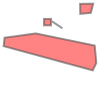

In [195]:
from shapely.geometry import MultiPolygon

zones = {}

for name, shapes in zones_data.items():
    zones[name] = MultiPolygon(shapes) if len(shapes) > 1 else shapes[0]

zones_for_df = []

for name, geometry in zones.items():
    if name+'_' in list(zones.keys()):
        zones[name] = geometry.difference(zones[name+'_'])
    if not name.endswith('_'):
        zones_for_df.append({'name': name, 'geometry': zones[name]})

zones_df = pd.DataFrame(zones_for_df)

zones_df.geometry[1]